In [1]:
# The wavelet coeeficient I plotted, shows the captured details of the signal 
# at different scales.
# The lmax is different, increase nside, gets subdivide the sphere into more
# pixels, and the lmax is increased.
# number of pixels  

# Can you increase lmax and plot the wv coefficients for the same signal at the scale,
# yes, but you will hacve to add zeros, becuase there is no details
# to make the picture clear.

# We use wavelet to filter out a lot of large amplitude fluctuations, and small scale of details
# and the small scale of details are noise

In [10]:
# import os

# # Define the folder name
# folder_name = "wavelet_transform"

# # Define the full path where you want to create the folder
# # You can modify this path to wherever you need the folder
# path = os.path.join(os.getcwd(), folder_name)

# # Check if the folder already exists
# if not os.path.exists(path):
#     os.makedirs(path)  # Create the folder
#     print(f"Folder '{folder_name}' created at {path}")
# else:
#     print(f"Folder '{folder_name}' already exists at {path}")

Folder 'wavelet_transform' created at /home/max/CMB_plot/code/wavelet_transform


In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt
%matplotlib inline 


frequency = "030"
# Step 1: Read the Healpix map
CMB_map_path = f'../data/planck_simulation/ffp10_newdust_total_{frequency}_full_map.fits'
original_healpix_map = hp.read_map(CMB_map_path)



In [3]:
print(original_healpix_map.shape[0])
l = hp.map2alm(original_healpix_map, lmax=2048)
l.shape

12582912


(2100225,)

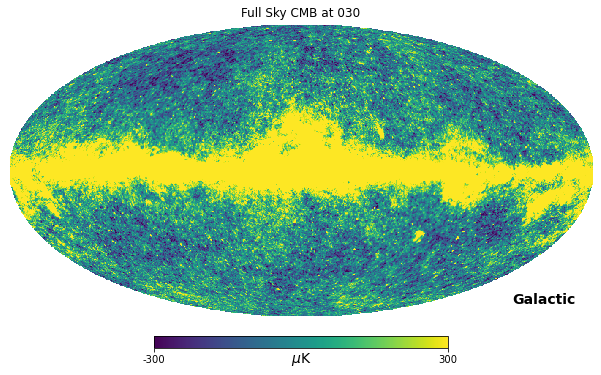

In [4]:
hp.mollview(
        original_healpix_map*1e6,
        coord=["G"],
        title="Full Sky CMB at "+frequency,
        unit=r"$\mu$K",
        min=-300, 
        max=300,
    )


In [5]:
# Step 2: Convert Healpix map to spherical harmonic coefficients
# convention: L_max = nside * 2
nside = hp.get_nside(original_healpix_map)
L_max = nside*2  # Define maximum multipole moment / detail level
hp_alm = hp.map2alm(original_healpix_map, lmax=L_max-1)
# lmax = L_max - 1 because python is 0-indexed

In [6]:
def hp_alm_2_mw_alm(hp_alm, lmax, Store=False, path=None):
    # Initialize the 2D MW_alm array with correct dimensions
    MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

    for l in range(L_max):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if m < 0:
                MW_alm[l, L_max + m - 1] = (-1)**m * np.conj(hp_alm[index])
            else:
                MW_alm[l, L_max + m - 1] = hp_alm[index]
    # np.save(".npy", MW_alm)
    # np.save(f'/wavelet_transform/maps/original_MW_map_{frequency}.npy', original_MW_Map)

    # # Optionally store the array
    # if Store:
    #     if path is None:
    #         np.save("MW_alm_1.npy", MW_alm)
    #     else:
    #         np.save(path, MW_alm)
    
    return MW_alm

def mw_alm_2_hp_alm(MW_alm, lmax):
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]
    
    return hp_alm



In [7]:
mw_alm = hp_alm_2_mw_alm(hp_alm, L_max)
mw_alm.shape
# mw_alm = alm_2d.copy()
# mw_alm.shape

(2048, 4095)

In [8]:
# Step 4: Apply s2fft to the 2d alm to get the map in MW sampling (2d)
original_MW_Map = s2fft.inverse(mw_alm, L_max)
np.save(f'wavelet_transform/maps/Original_MW_Pix_map_{frequency}.npy', original_MW_Map)
stored_original_MW_Pix_map = np.load(f'wavelet_transform/maps/Original_MW_Pix_map_{frequency}.npy')

In [9]:
np.save(f'wavelet_transform/maps/Original_MW_Pix_map_{frequency}.npy', original_MW_Map)
stored_original_MW_Pix_map = np.load(f'wavelet_transform/maps/Original_MW_Pix_map_{frequency}.npy')

In [10]:
# Step 5: Apply s2wav to the MW map to get the wavelet and scaling coefficients
N_directions = 1  # Number of directional wavelets
filter = filters.filters_directional_vectorised(L_max, N_directions)

wavelet_coeffs, scaling_coeffs = s2wav.analysis(stored_original_MW_Pix_map, L_max, N_directions, filters=filter,reality = False)

# Convert each element in f_wav to a numpy array and save it
for i, wav in enumerate(wavelet_coeffs):
    np_wav = np.array(wav)  # Convert JAX array to numpy array
    np.save(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S{i}", np_wav)  

# Convert  f_scal to a numpy array and save it
np_scal = np.array(scaling_coeffs)  # Convert JAX array to numpy array
np.save(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequency}", np_scal)  
stored_wavelet_coeffs = [np.load(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S{i}.npy", allow_pickle=True) for i in range(12)]
stored_scaling_coeffs = np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequency}.npy")


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [11]:
reconstructed_MW_map_raw = s2wav.synthesis(stored_wavelet_coeffs, stored_scaling_coeffs, L_max, N_directions, filters=filter, reality = False)

reconstructed_MW_map = np.array(reconstructed_MW_map_raw)
np.save(f"wavelet_transform/maps/Reconstructed_MW_Pix_map_{frequency}", reconstructed_MW_map)  # Save numpy array to a file
stored_reconstructed_MW_map = np.load(f"wavelet_transform/maps/Reconstructed_MW_Pix_map_{frequency}.npy")
reconstructed_MW_map_raw.shape

(2048, 4095)

In [12]:
print(f"Mean absolute error = {np.nanmean(np.abs(stored_reconstructed_MW_map - stored_original_MW_Pix_map))}")

Mean absolute error = 5.027814000446272e-15


In [13]:
# Step 2: Perform spherical harmonic transform using s2fft
alm_reconstructed_MW_map = s2fft.forward(stored_reconstructed_MW_map, L_max)


In [14]:
np.save(f'wavelet_transform/alms/Reconstructed_MW_alm_{frequency}', alm_reconstructed_MW_map)
stored_reconstructed_MW_alm = np.load(f'wavelet_transform/alms/Reconstructed_MW_alm_{frequency}.npy')
stored_reconstructed_MW_alm.shape

(2048, 4095)

In [21]:
# reconstructed_healpix_alm.shape

(2098176,)

In [15]:
# # Step 3: Rearrange coefficients for healpy
# n_coeff = hp.Alm.getsize(L_max-1)
# reconstructed_healpix_alm = np.zeros(n_coeff, dtype=np.complex128)

# for l in range(L_max):
#     for m in range(-l, l + 1):
#         alm_index = hp.Alm.getidx(L_max - 1, l, abs(m))
#         if alm_index >= n_coeff:
#             print(f"Index {alm_index} is out of bounds for alm with size {n_coeff}")
#             continue
#         if m < 0:
#             reconstructed_healpix_alm[alm_index] = (-1) ** m * np.conj(stored_alm_reconstructed_MW_map[l, L_max + m - 1])
#         else:
#             reconstructed_healpix_alm[alm_index] = stored_alm_reconstructed_MW_map[l, L_max + m - 1]
# Both are equal 

def mw_alm_2_hp_alm(MW_alm, lmax):
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
        
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]

    return hp_alm
# MW_alm2 = stored_alm_reconstructed_MW_map.copy()
# L_max = 2048
lmax = L_max-1
hp_alm1 = mw_alm_2_hp_alm(stored_reconstructed_MW_alm,L_max-1)

In [16]:
# Now `alm` is ready to be used with healpy
nside = L_max // 2
# healpix_map = hp.alm2map(reconstructed_healpix_alm, nside, verbose=False)
reconstructed_healpix_map = hp.alm2map(hp_alm1, nside, verbose=False)

# Save the HEALPix map to a FITS file
output_fits_path = f'wavelet_transform/maps/reconstructed_healpix_map_{frequency}.fits'
hp.write_map(output_fits_path, reconstructed_healpix_map, overwrite=True, dtype=np.float64)
new_healpix_map = hp.read_map(output_fits_path)

In [20]:
# output_fits_path = f'reconstructed_healpix_map_{frequency}.fits'

# new_healpix_map = hp.read_map(output_fits_path)

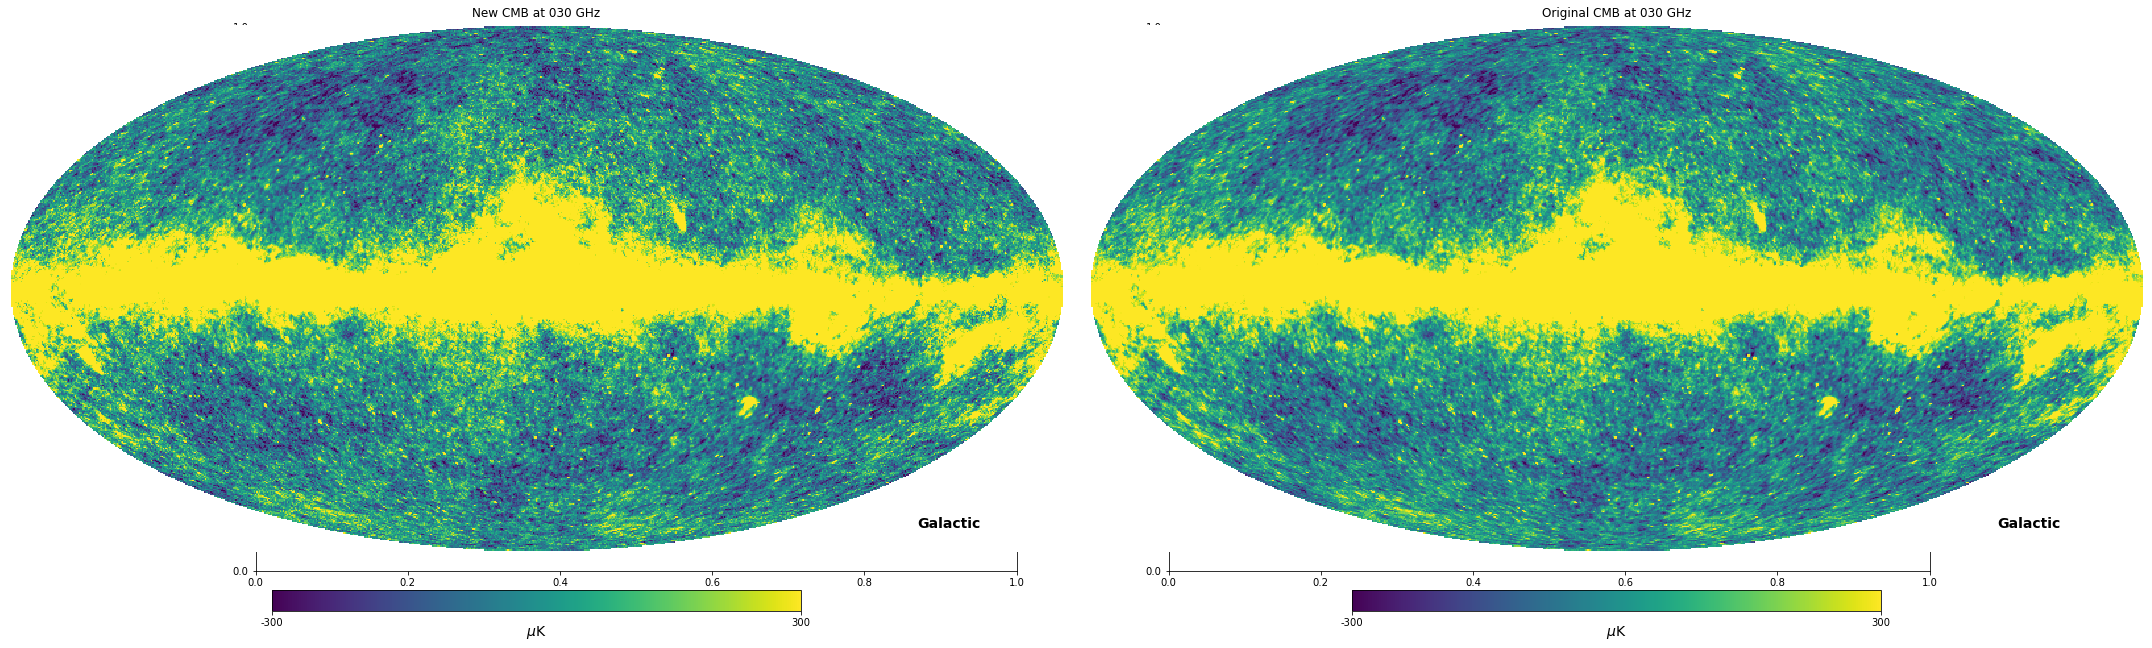

In [17]:
# Create a new figure
fig = plt.figure(figsize=(30,10))

# Plot the new HEALPix map
ax1 = fig.add_subplot(1, 2, 1)
hp.mollview(
    original_healpix_map * 1e6,
    coord=["G"],
    title="New CMB at " + frequency + " GHz",
    unit=r"$\mu$K",
    min=-300,
    max=300,
    fig=fig,
    sub=(1, 2, 1)  # Subplot configuration
)

# Plot the original HEALPix map
ax2 = fig.add_subplot(1, 2, 2)
hp.mollview(
    new_healpix_map * 1e6,
    coord=["G"],
    title="Original CMB at " + frequency + " GHz",
    unit=r"$\mu$K",
    min=-300,
    max=300,
    fig=fig,
    sub=(1, 2, 2)  # Subplot configuration
)

plt.show()

In [18]:
difference = new_healpix_map-original_healpix_map

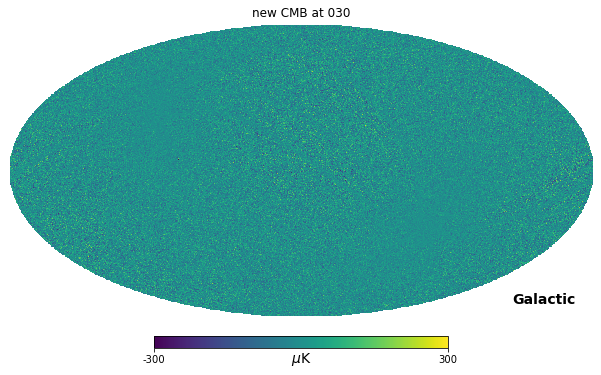

In [19]:

hp.mollview(
        difference*1e6,
        coord=["G"],
        title="new CMB at "+frequency,
        unit=r"$\mu$K",
        min=-300, 
        max=300,
    )


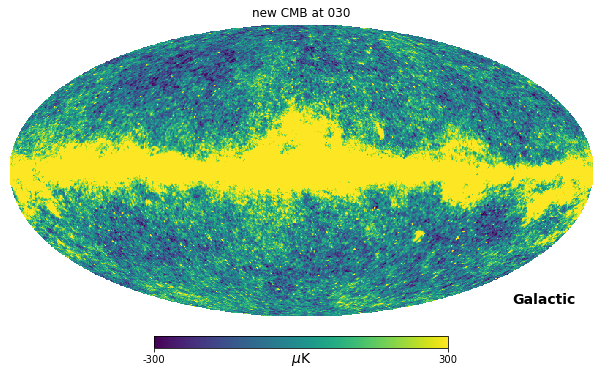

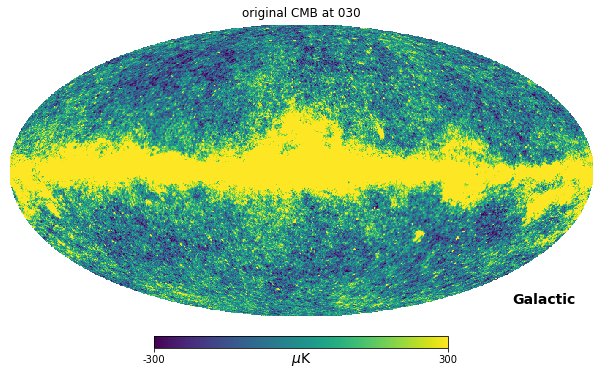

In [20]:

hp.mollview(
        new_healpix_map*1e6,
        coord=["G"],
        title="new CMB at "+frequency,
        unit=r"$\mu$K",
        min=-300, 
        max=300,
    )

hp.mollview(
        original_healpix_map*1e6,
        coord=["G"],
        title="original CMB at "+frequency,
        unit=r"$\mu$K",
        min=-300, 
        max=300,
    )

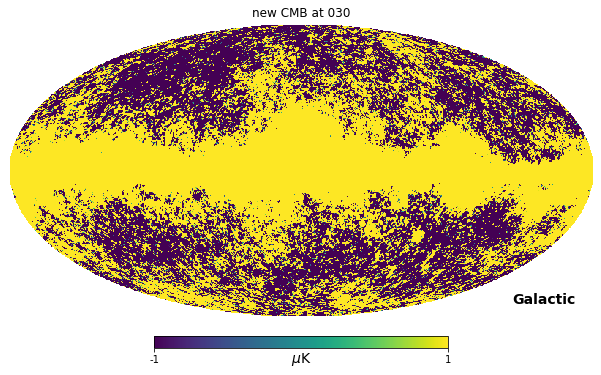

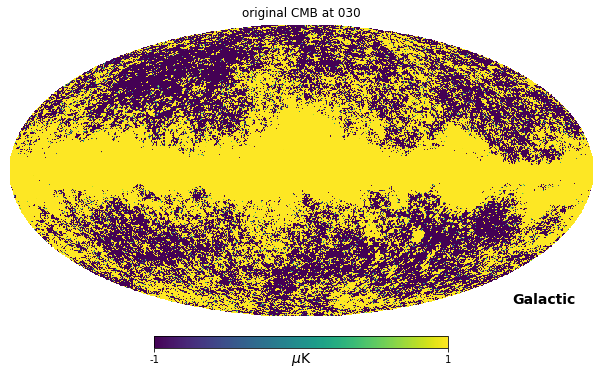

In [21]:
hp.mollview(
        new_healpix_map*1e5,
        coord=["G"],
        title="new CMB at "+frequency,
        unit=r"$\mu$K",
        min=-1, 
        max=1,
    )

hp.mollview(
        original_healpix_map*1e5,
        coord=["G"],
        title="original CMB at "+frequency,
        unit=r"$\mu$K",
        min=-1, 
        max=1,
    )

In [22]:
print(len(stored_wavelet_coeffs))

12


In [23]:
for i in range(len(stored_wavelet_coeffs)):
    print(f"Shape of wavelet_coeffs:{i} {stored_wavelet_coeffs[i].shape}")
# print(f"Shape of wavelet_coeffs: {stored_wavelet_coeffs[1].shape}")

Shape of wavelet_coeffs:0 (1, 4, 7)
Shape of wavelet_coeffs:1 (1, 4, 7)
Shape of wavelet_coeffs:2 (1, 8, 15)
Shape of wavelet_coeffs:3 (1, 16, 31)
Shape of wavelet_coeffs:4 (1, 32, 63)
Shape of wavelet_coeffs:5 (1, 64, 127)
Shape of wavelet_coeffs:6 (1, 128, 255)
Shape of wavelet_coeffs:7 (1, 256, 511)
Shape of wavelet_coeffs:8 (1, 512, 1023)
Shape of wavelet_coeffs:9 (1, 1024, 2047)
Shape of wavelet_coeffs:10 (1, 2048, 4095)
Shape of wavelet_coeffs:11 (1, 2048, 4095)


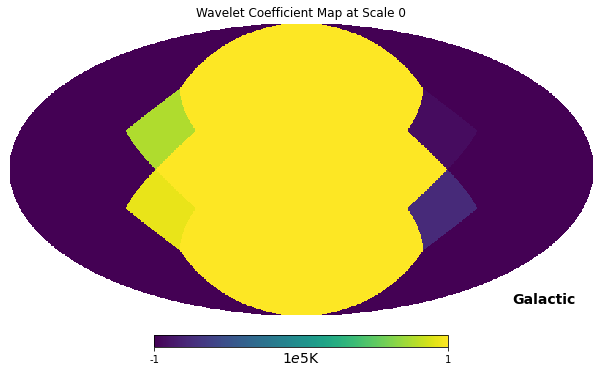

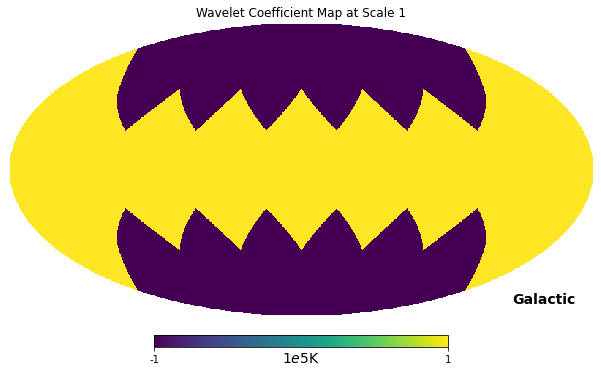

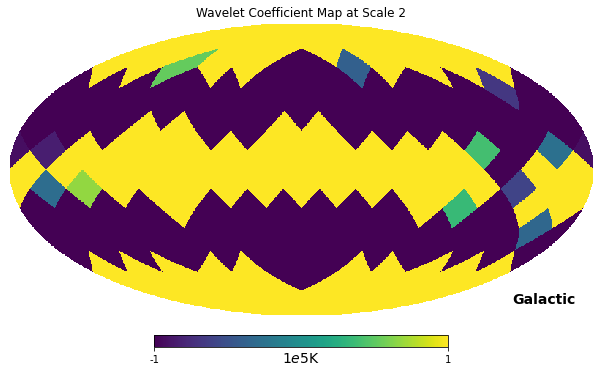

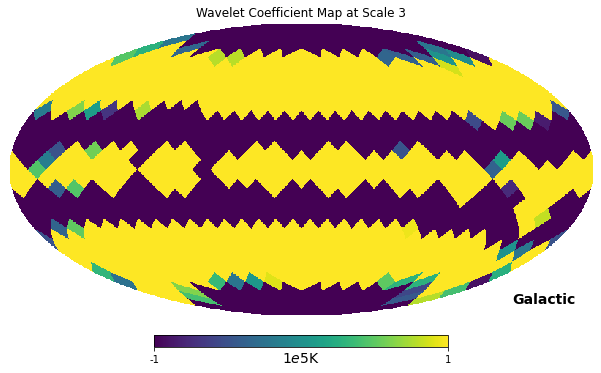

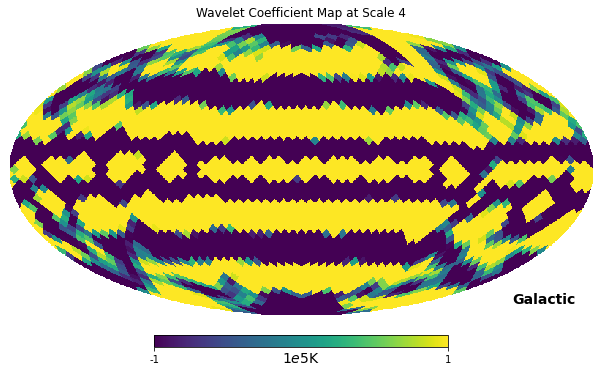

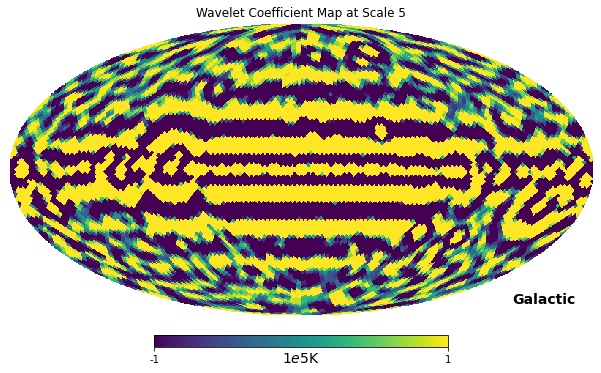

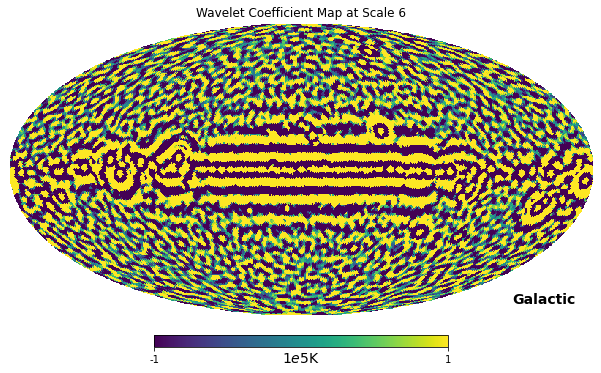

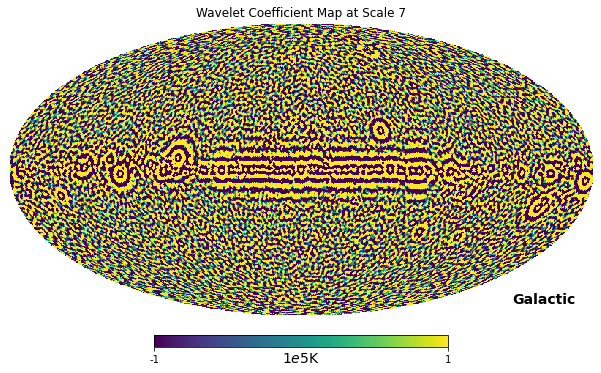

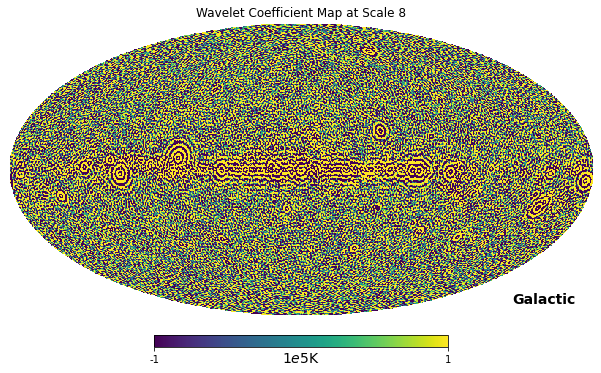

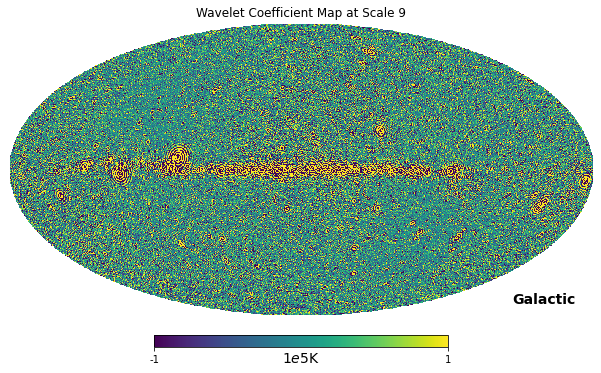

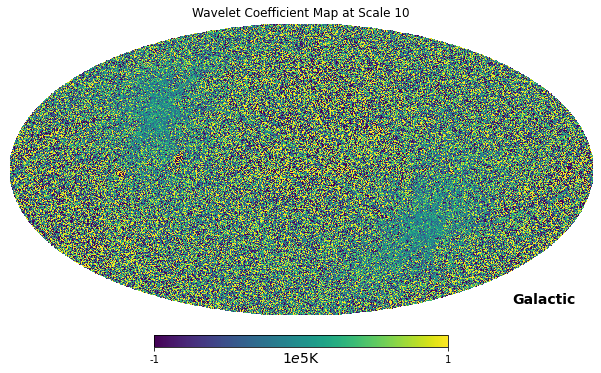

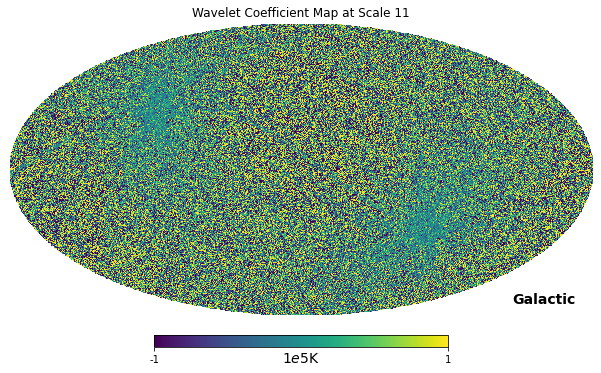

In [24]:
# stored_wavelet_coeffs = [np.load(f"../convolution/wavelet_coefficient/wav_{frequency}_{i}.npy", allow_pickle=True) for i in range(12)]
# stored_scaling_coeffs = np.load(f"../convolution/scaling_coefficient/scal_{frequency}.npy")

for i in range(len(stored_wavelet_coeffs)):
    # perform a forward transformation to convert 
    # the wavelet coefficients into the spherical harmonic alm space (2D).

    wavelet_in_alm = s2fft.forward(stored_wavelet_coeffs[i], L = stored_wavelet_coeffs[i].shape[1])
    alm_reconstructed_MW_map = wavelet_in_alm 
    L_max = stored_wavelet_coeffs[i].shape[1]
    np.save(f"wavelet_transform/wavelets/wav_MW_alms/Wav_MW_alm_F{frequency}_S{i}", alm_reconstructed_MW_map)  # Save numpy array to a file
    
    #Rearrange coefficients for healpy (1D).
    n_coeff = hp.Alm.getsize(L_max-1)
    reconstructed_healpix_alm_1 = np.zeros(n_coeff, dtype=np.complex128)
    
    for l in range(L_max):
        for m in range(-l, l + 1):
            alm_index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if alm_index >= n_coeff:
                print(f"Index {alm_index} is out of bounds for alm with size {n_coeff}")
                continue
            if m < 0:
                reconstructed_healpix_alm_1[alm_index] = (-1) ** m * np.conj(alm_reconstructed_MW_map[l, L_max + m - 1])
            else:
                reconstructed_healpix_alm_1[alm_index] = alm_reconstructed_MW_map[l, L_max + m - 1]
    
    # Use the alm2map function to convert them into a Healpix map.
    nside = L_max // 2
    wavelet_healpix_map = hp.alm2map(reconstructed_healpix_alm_1, nside, verbose=False)
    np.save(f"wavelet_transform/wavelets/wav_hp_maps/Wav_hp_map_F{frequency}_S{i}",wavelet_healpix_map)  # Save numpy array to a file
    wavelet_scale = str(i)
    
    # Use hp.mollview to plot the wavelet coefficient map.

    hp.mollview(
            wavelet_healpix_map*1e5,
            coord=["G"],
            title="Wavelet Coefficient Map at Scale "+wavelet_scale,
            unit=r"$1e5$K",
            min=-1, 
            max=1,
        )



In [26]:
# frequency = "070"

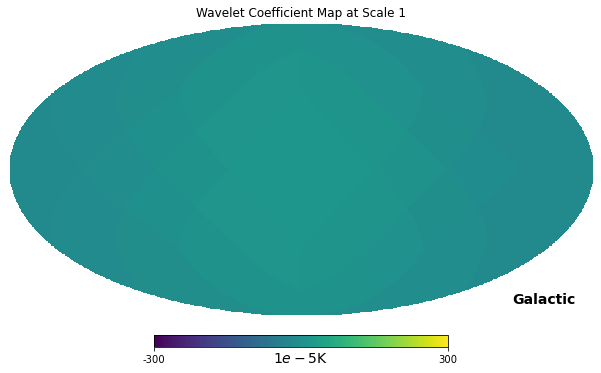

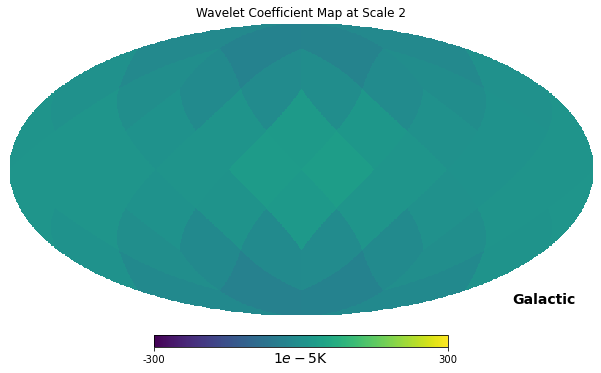

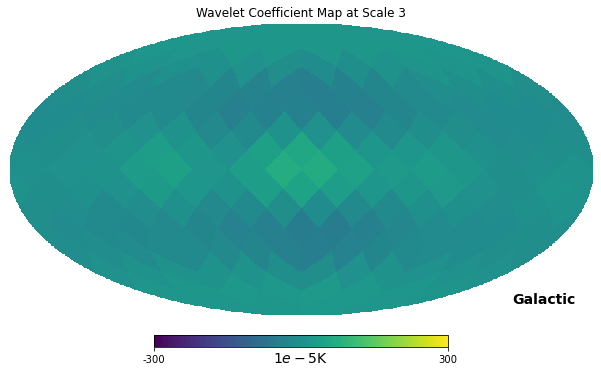

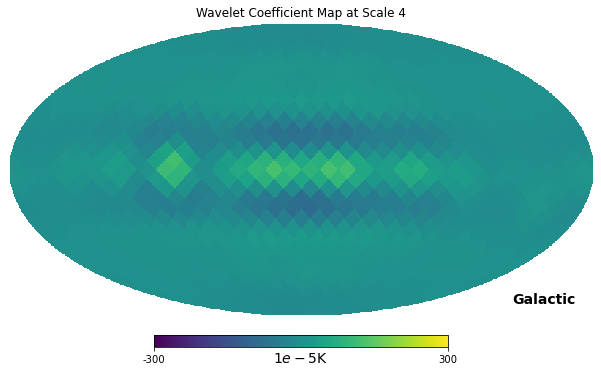

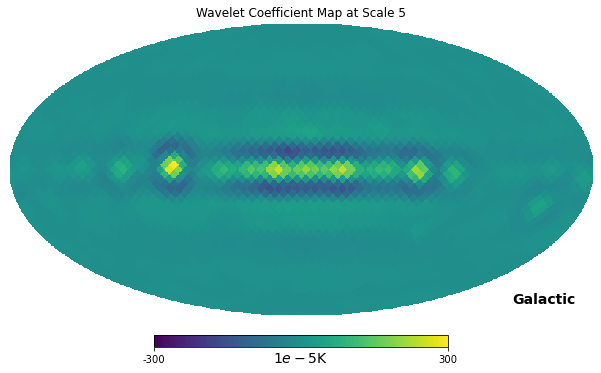

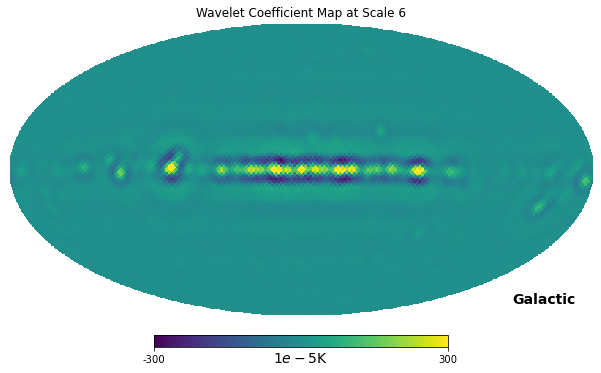

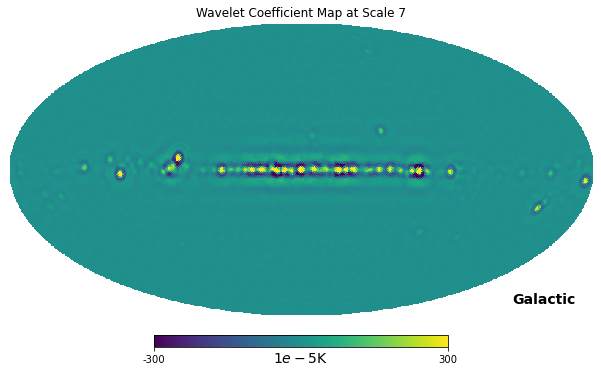

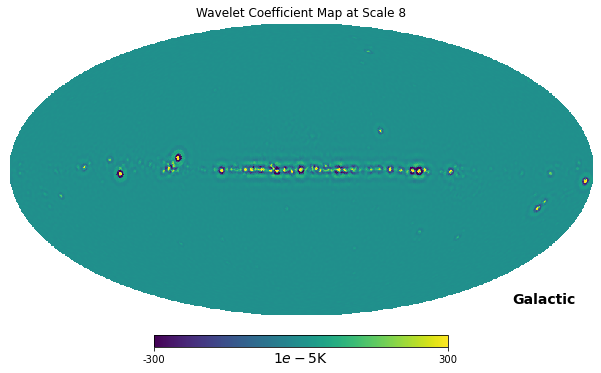

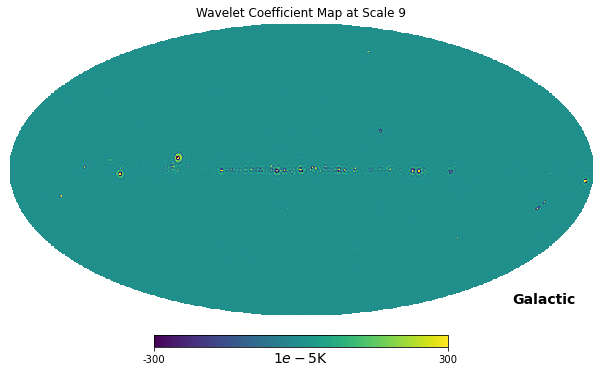

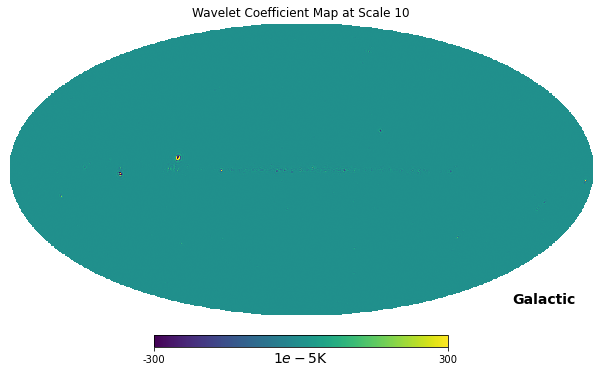

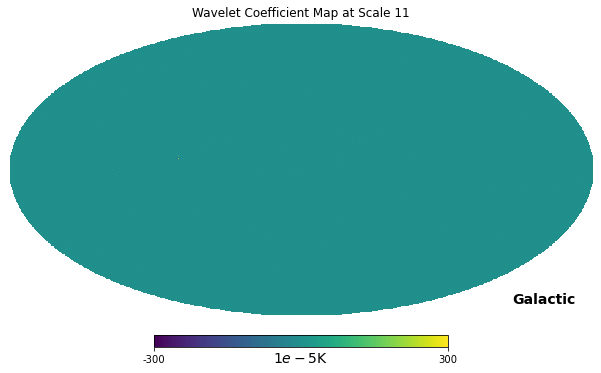

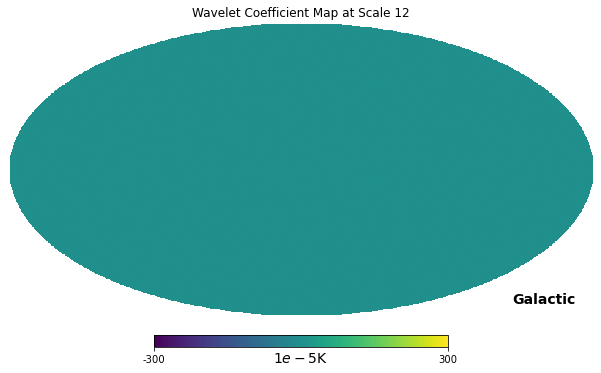

In [26]:

for i in [0,1,2,3,4,5,6,7,8,9,10,11]:

    wavelet_healpix_map = np.load(f"wavelet_transform/wavelets/wav_hp_maps/Wav_hp_map_F{frequency}_S{i}.npy") 
    wavelet_scale = str(i+1)
    hp.mollview(
            wavelet_healpix_map*1e5,
            coord=["G"],
            title="Wavelet Coefficient Map at Scale "+wavelet_scale,
            unit=r"$1e-5$K",
            min=-300, 
            max=300,
        )       
